<h1>Mô hình LSTM trong bảo trì dự đoán</h1>

## Table of Contents
* [Install Libraries](#ins-lib)
* [Data pre-processing](#data-preprocess)
  * [Đọc dữ liệu](#read-data)
  * [Lựa chọn thuộc tính đầu vào của mô hình](#select-arg)
  * [Chuẩn hóa dữ liệu](#standardization)
  * [Lựa chọn tập dữ liệu](#select-dataset)
* [Training model and prediction](#training)
  * [Convert Time series to Supervised Learning](#convert)
  * [Data spliting into train and test data series](#data-split)
  * [Build model](#build)
  * [Predict](#predict)
  

## Install Libraries <a id="ins-lib"></a>

In [ ]:
# !pip3 install --upgrade tensorflow
# pip3 install h5py
# !pip3 install keras
# !pip3 install matplotlib
# !pip3 install pandas
# !pip3 install sklearn
# !pip3 install h5py

## Data pre-processing <a id="data-preprocess"></a>
### Đọc dữ liệu <a id="read-data"></a>

In [1]:
import pandas as pd
data = pd.read_csv("./sensor.csv")
data.shape

(220320, 55)

In [3]:
# Xóa các cột có giá trị NaN hoặc bằng 0 
data.drop(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_15','sensor_50', 'sensor_51'], axis=1, inplace=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

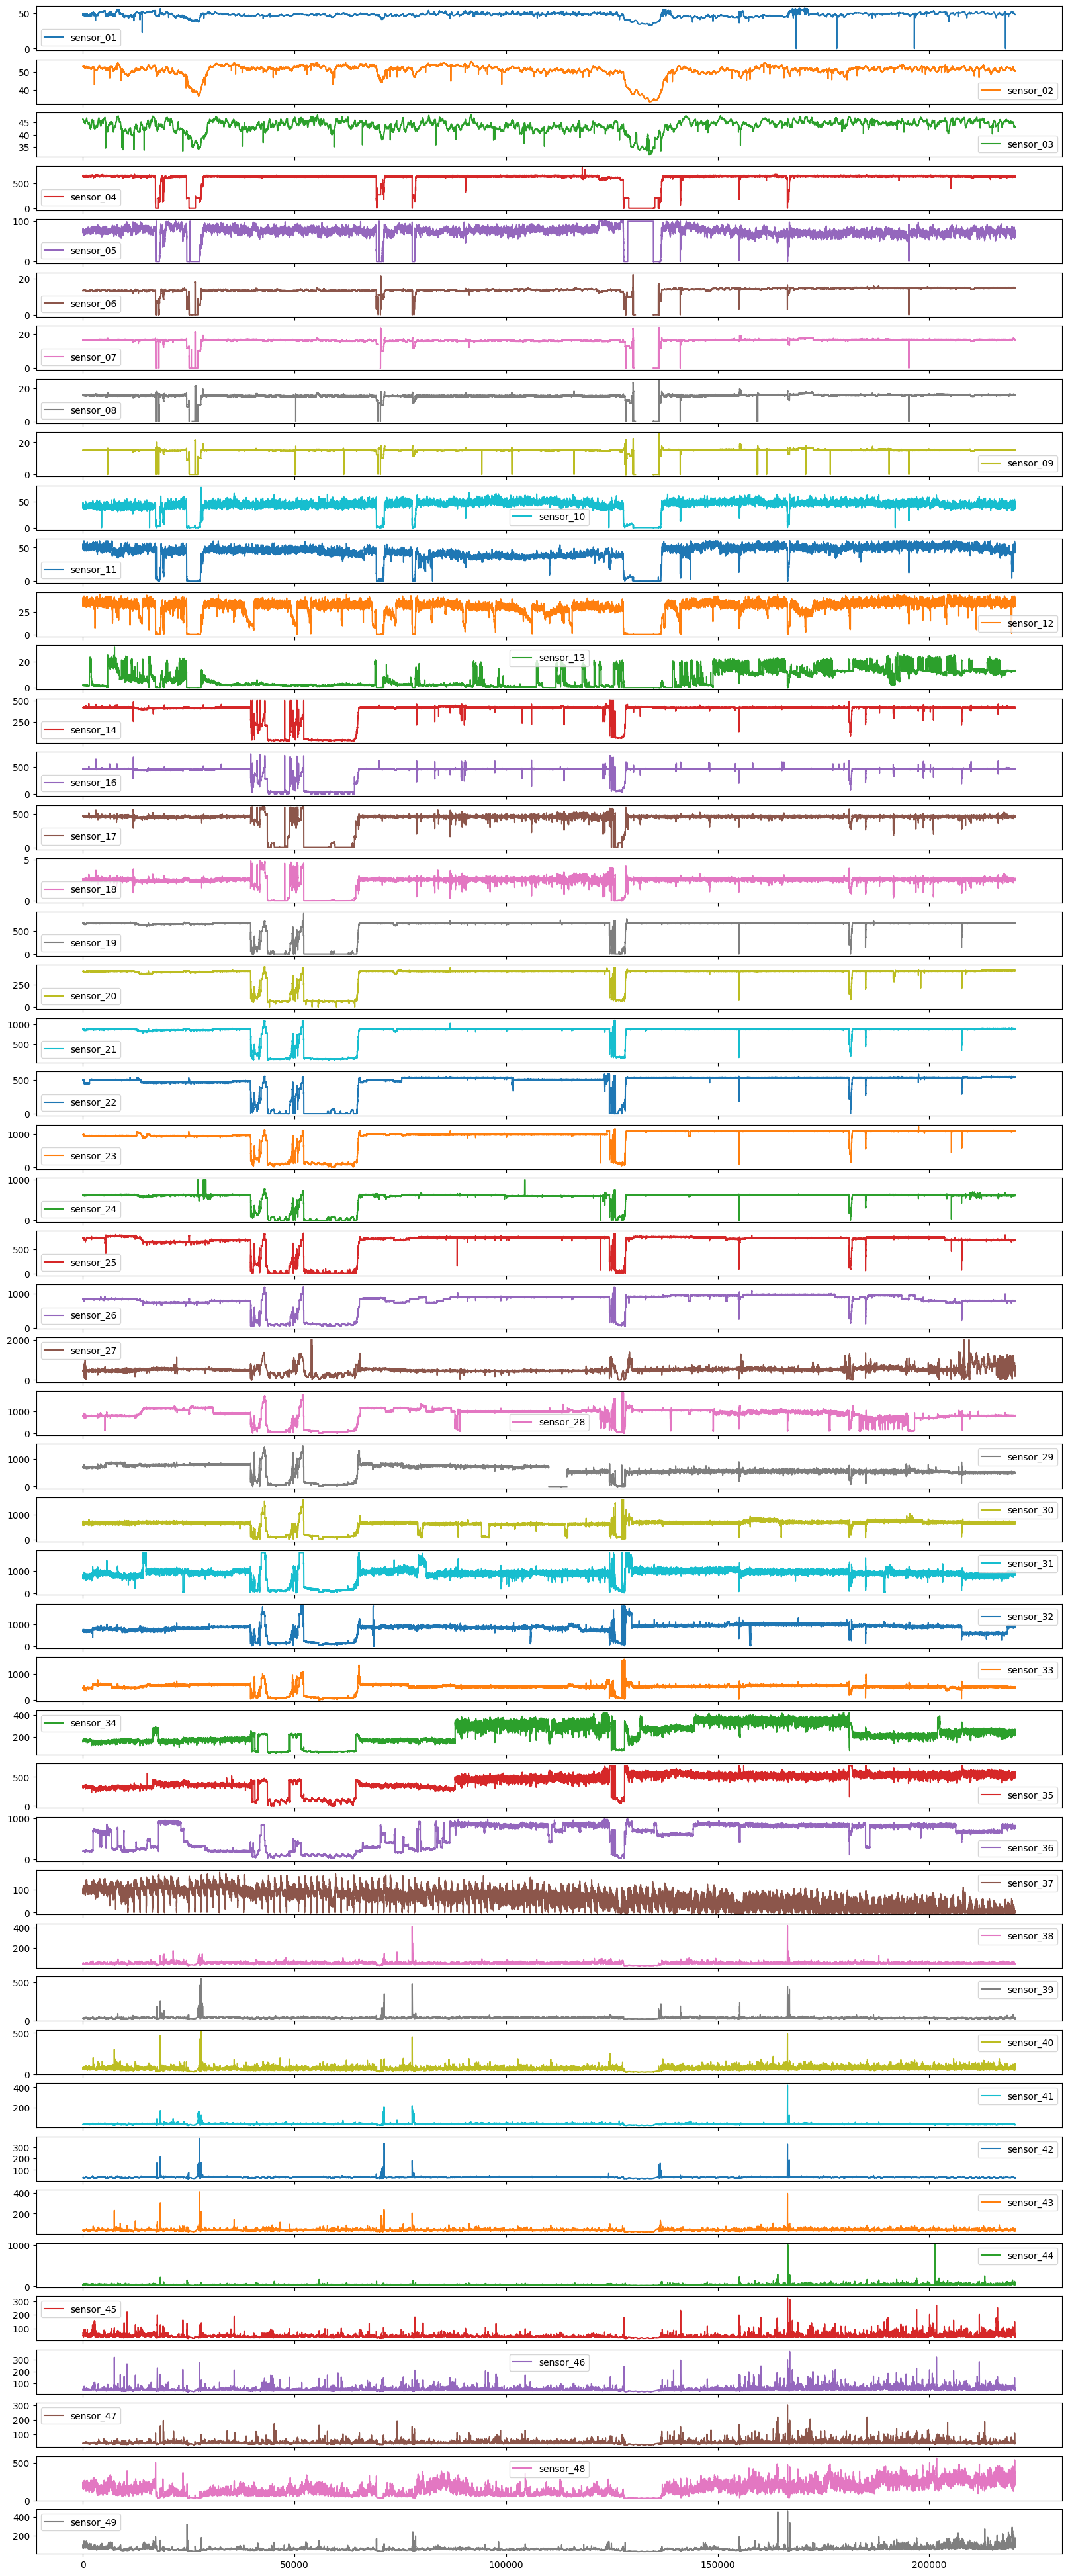

In [4]:
# Visualize chỉ số của các sensor
import matplotlib.pyplot as plt
data.plot(subplots = True, sharex = True, figsize = (20,50))

<span>Từ đồ thị có thể thấy rằng một pattern có thể được do bằng một số sensor, Ví dụ </h4>
<ul>
    <li>1,23</li>
    <li>4,5,6,7,8,9</li>
    <li>10,11,12</li>
    <li>14,16,17,18</li>
    <li>19,20,21,22,23,24</li>
    <li>25,26,28,29,30,31,32,33</li>
    <li>34,35</li>
    <li>38,39,40,41,42,43,45,46,47</li>
</ul>

### Lựa chọn tham số đầu vào mô hình <a id="select-arg"></a>

In [5]:
data['machine_status'].value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

<ul>
    <li>NORMAL: Máy hoạt động bình thường</li>
    <li>RECOVERING: Máy trong quá trình recover</li>
    <li>BROKEN: Máy bị lỗi</li>
</ul>
<p>Dataset có 7 trạng thái bị hỏng. Để đơn giản, chúng ta chọn 25% dữ liệu cho huấn luyện (gồm 2 trạng thái bị hỏng), và 75% dữ liệu cho testing (gồm 5 trạng thái bị hỏng còn lại)</p>

### Chuẩn hóa dữ liệu <a id="standardization"></a>

In [6]:
import numpy as np
conditions = [(data['machine_status'] == 'NORMAL'), (data['machine_status'] == 'BROKEN'), (data['machine_status'] == 'RECOVERING')]
choices = [1, 0, 0.5]
# create new column "Operation"
data['Operation'] = np.select(conditions,choices, default=0)

### Lựa chọn tập dữ liệu <a id="select-dataset"></a>
Loại bỏ các dữ liệu không sử dụng bằng cách chia tập các sensor và tìm ra sự tương quan đến sự cố của máy 
<ul>
    <li>
        Set 0: sensors numbers 4, 6, 7, 8, 9
    </li>
    <li>
        Set 1: sensors numbers 1, 4, 10, 14, 19, 25, 34, 38
    </li>
    <li>
        Set 2: sensors numbers 2, 5, 11, 16, 20, 26, 39
    </li>
    <li>
        Set 3: sensors numbers 3, 6, 12, 17, 21, 28, 40
    </li>
</ul>
Set 0 có tương quan với trạng thái hỏng của máy do đó được chọn để đưa vào training

In [18]:
df = pd.DataFrame(data, columns=['Operation','sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09'])

,Operation,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09
0,1.0,634.3750,13.41146,16.13136,15.56713,15.05353
1,1.0,634.3750,13.41146,16.13136,15.56713,15.05353
2,1.0,638.8889,13.32465,16.03733,15.61777,15.01013
3,1.0,628.1250,13.31742,16.24711,15.69734,15.08247
4,1.0,636.4583,13.35359,16.21094,15.69734,15.08247


### Training model and prediction <a id="training"></a>
<span>Training set: Gồm 50000 điểm dữ liệu với 2 lần máy bị hỏng</span></br>
<span>Testing set: Gồm 175000 điểm dữ liệu với 5 lần máy bị hỏng</span>

### Convert Time series to Supervised Learning <a id="convert"></a>

In [8]:
"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
def series_to_supervised(data, n_in=1, n_out=5, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu về đoạn [0,1]
values = df.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled,1,1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
0,1.0,0.792242,0.602472,0.683630,0.638905,0.602141,1.0
1,1.0,0.797904,0.598568,0.679645,0.640988,0.600405,1.0
2,1.0,0.784402,0.598243,0.688535,0.644259,0.603299,1.0
3,1.0,0.794855,0.599870,0.687002,0.644259,0.603299,1.0
4,1.0,0.796307,0.602472,0.685162,0.652290,0.606482,1.0


### Data spliting into train and test data series <a id="data-split"></a>
Dataset được chia thành tập huấn luyện và tập kiểm tra
<ul>
    <li>Tập huấn luyện gồm 50.000 dòng</li>
    <li>Tập kiểm tra gồm 175.000 dòng</li>
</ul>



In [29]:
values = reframed.values
n_train_time = 50000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]   # train_x: n-1 cột đầu tiên, train_y: cột cuối cùng (operation)
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

### Build model <a id="build"></a>

In [11]:
units = 100   # hidden_nodes
epochs = 150  # Số lần duyệt qua hết các dữ liệu trong tập huấn luyện
batch_size = 70 # Số dữ liệu sử dụng trong 1 lần cập nhật trọng số 
verbose = 2
# Ví dụ trong bài toán phân loại: Mỗi lần đưa vào mạng 32 hình ảnh (batch_size = 32). Sau khi đưa nhiều lần
# đến khi không còn hình ảnh để đưa vào nữa thì hoàn thành 1 epoch

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np 

# build model
model = Sequential()
model.add(LSTM(units, input_shape=(train_x.shape[1], train_x.shape[2]) ))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit model
history = model.fit(train_x, train_y, epochs, batch_size, validation_data=(test_x, test_y), verbose=2, shuffle=False)
model.save('model.h5')


In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
model = load_model('model.h5')
size = df.shape[1]

# prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape(test_x.shape[0], size)

# invert scalling
inv_yhat = np.concatenate((yhat, test_x[:,1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape(len(test_y), 1)
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# caculate RSME
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
accuracy = accuracy_score(inv_y, inv_yhat)
print('Test RSME: %.3f' % rmse)

### Predict <a li="predict"></a>

In [ ]:
import numpy as np
e = np.round(sum(np.abs(inv_y[:]-inv_yhat[:]))/(sum(inv_y[:])*len(inv_y[:]))*100,2)
aa=[x for x in range(160000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:160000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:160000], 'r', label="prediction with precision of {} %".format(e))
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show()